In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# 0. Imports
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 1. Load VHLSS modules
# ─────────────────────────────────────────────────────────────────────────────
# Replace filenames if necessary
df1        = pd.read_csv('muc123a.csv')    # demographics: gender, role, age
df2        = pd.read_csv('muc4a.csv')      # income: labour income, other cash
df_hhexpe  = pd.read_csv('hhexpe08.csv')   # household expenditure (optional)
df4d = pd.read_csv('muc4d.csv') # wealth: gold, jewelry, etc.

# ─────────────────────────────────────────────────────────────────────────────
# 2. Filter: keep only households with male heads
# ─────────────────────────────────────────────────────────────────────────────
male_head_filter = (
    df1
      .groupby(['tinh', 'huyen', 'xa', 'hoso'])
      .filter(lambda g: ((g['m1ac3'] == 1) & (g['m1ac2'] == 1)).any())
)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Create household ID and build basic member-level table G_t
# ─────────────────────────────────────────────────────────────────────────────
male_head_filter['ID'] = (
    male_head_filter[['tinh', 'huyen', 'xa', 'diaban', 'hoso']]
    .astype(str)
    .agg('_'.join, axis=1)
)

G_t = male_head_filter[['ID', 'm1ac2', 'm1ac3', 'm1ac5']].rename(
    columns={'m1ac2': 'gender', 'm1ac3': 'role', 'm1ac5': 'age'}
)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Add income to G_t
# ─────────────────────────────────────────────────────────────────────────────
# Income from m4ac11 + m4ac12f
G_t['Income'] = (
    df2[['m4ac11', 'm4ac12f']]
      .sum(axis=1, skipna=True)
)

# ─────────────────────────────────────────────────────────────────────────────
# 5. Aggregate to household level: total income and head's age
# ─────────────────────────────────────────────────────────────────────────────
G_t_malehead = (
    G_t.groupby('ID')
      .filter(lambda g: ((g['gender'] == 1) & (g['role'] == 1)).any())
)

household_income = (
    G_t_malehead
      .groupby('ID')['Income']
      .sum()
      .reset_index(name='total_income')
)

head_age = (
    G_t_malehead
      .loc[(G_t_malehead['gender'] == 1) & (G_t_malehead['role'] == 1)]
      .groupby('ID')['age']
      .first()
      .reset_index(name='head_age')
)

household_income = household_income.merge(head_age, on='ID', how='left')

# ─────────────────────────────────────────────────────────────────────────────
# 6. Compute G_t for each 5-year age bucket
# ─────────────────────────────────────────────────────────────────────────────
# (a) Take log of total income
household_income['log_total_income'] = np.log(
    household_income['total_income'].clip(lower=1)
)

# (b) Create 5-year bins
age_min = 15
age_max = household_income['head_age'].max() + 5
bins    = np.arange(age_min, age_max + 1, 5)    # 15,20,25,…,100
labels  = [f'{b}-{b+4}' for b in bins[:-1]]     # '15-19','20-24',…

household_income['age_5yr'] = pd.cut(
    household_income['head_age'],
    bins=bins,
    labels=labels,
    right=False
)

# (c) Group by age bucket and calculate average log income
G_t_5yr = (
    household_income
      .groupby('age_5yr')['log_total_income']
      .mean()
      .reset_index(name='average_log_income')
      .dropna()
)

# (d) Exponentiate to get G_t
G_t_5yr['G_t'] = np.exp(G_t_5yr['average_log_income'])

# ─────────────────────────────────────────────────────────────────────────────
# 7. Final output
# ─────────────────────────────────────────────────────────────────────────────
print(G_t_5yr)

   age_5yr  average_log_income         G_t
0    15-19            2.076960    7.980175
1    20-24            2.141264    8.510185
2    25-29            4.364367   78.599629
3    30-34            4.386876   80.388930
4    35-39            5.032678  153.343114
5    40-44            5.177202  177.186290
6    45-49            5.058701  157.386007
7    50-54            4.773679  118.353917
8    55-59            4.787601  120.013066
9    60-64            4.785333  119.741284
10   65-69            4.519753   91.812923
11   70-74            3.818519   45.536698
12   75-79            4.439784   84.756616
13   80-84            4.247340   69.919195
14   85-89            4.087548   59.593613
15   90-94            2.946499   19.039189
16   95-99            5.282920  196.944155


In [4]:
import pandas as pd

# Load the new data from muc4d.csv
muc4d = pd.read_csv('muc4d.csv')

# Create a new 'ID' column in muc4d by combining 'tinh', 'huyen', 'xa', 'diaban', and 'hoso'
muc4d['ID'] = muc4d['tinh'].astype(str) + '_' + muc4d['huyen'].astype(str) + '_' + muc4d['xa'].astype(str) + '_' + muc4d['diaban'].astype(str) + '_' + muc4d['hoso'].astype(str)

# Merge the 'wealth' column with the existing dataframes based on 'ID'
G_t = G_t.merge(muc4d[['ID', 'm4d2c2_3']], on='ID', how='left').rename(columns={'m4d2c2_3': 'wealth'})
G_t_malehead = G_t_malehead.merge(muc4d[['ID', 'm4d2c2_3']], on='ID', how='left').rename(columns={'m4d2c2_3': 'wealth'})
household_income = household_income.merge(muc4d[['ID', 'm4d2c2_3']], on='ID', how='left').rename(columns={'m4d2c2_3': 'wealth'})
head_age = head_age.merge(muc4d[['ID', 'm4d2c2_3']], on='ID', how='left').rename(columns={'m4d2c2_3': 'wealth'})

# Display the updated dataframes
G_t.head()
G_t_malehead.head()
household_income.head()
head_age.head()

,ID,head_age,wealth
0,101_11_1.0_10_13,43,0
1,101_11_1.0_10_14,53,0
2,101_11_1.0_10_15,44,0
3,101_11_17.0_33_13,38,15000
4,101_11_17.0_33_14,42,0


In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# 0. Imports
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 1. Load raw VHLSS modules
# ─────────────────────────────────────────────────────────────────────────────
df123 = pd.read_csv('muc123a.csv')   # demographics (person level)
df4a  = pd.read_csv('muc4a.csv')     # income flows   (person level)
df4d  = pd.read_csv('muc4d.csv')     # wealth stocks  (household level)

# ─────────────────────────────────────────────────────────────────────────────
# 2. Build member-level table  (gender, role, age, income)
# ─────────────────────────────────────────────────────────────────────────────
# Household ID  (tinh-huyen-xa-diaban-hoso)
df123['ID'] = (
    df123[['tinh','huyen','xa','diaban','hoso']]
    .astype(str).agg('_'.join, axis=1)
)

G_t = df123[['ID','m1ac2','m1ac3','m1ac5']].rename(
        columns={'m1ac2':'gender',
                 'm1ac3':'role',
                 'm1ac5':'age'}
)

# Income = m4ac11 + m4ac12f   (row-aligned with df4a)
G_t['Income'] = df4a[['m4ac11','m4ac12f']].sum(axis=1, skipna=True)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Keep only households with a **male head**
# ─────────────────────────────────────────────────────────────────────────────
is_male_head = (
    G_t.groupby('ID')
       .filter(lambda g: ((g['gender']==1) & (g['role']==1)).any())
)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Aggregate to household level
# ─────────────────────────────────────────────────────────────────────────────
household_income = (
    is_male_head
      .groupby('ID')['Income']
      .sum()
      .reset_index(name='total_income')
)

head_age = (
    is_male_head
      .loc[(is_male_head['gender']==1) & (is_male_head['role']==1)]
      .groupby('ID')['age']
      .first()
      .reset_index(name='head_age')
)

# ─────────────────────────────────────────────────────────────────────────────
# 5. Bring in **wealth** from muc4d  (household-level already)
# ─────────────────────────────────────────────────────────────────────────────
df4d['ID'] = (
    df4d[['tinh','huyen','xa','diaban','hoso']]
    .astype(str).agg('_'.join, axis=1)
)

wealth = df4d[['ID','m4d2c2_3']].rename(columns={'m4d2c2_3':'total_wealth'})

# ─────────────────────────────────────────────────────────────────────────────
# 6. Merge income, age, wealth  →  household_data
# ─────────────────────────────────────────────────────────────────────────────
household_data = (
    household_income
      .merge(head_age,   on='ID', how='left')
      .merge(wealth,     on='ID', how='left')
)

# ─────────────────────────────────────────────────────────────────────────────
# 7. Compute G_t (income)  &  average wealth by 5-year age group
# ─────────────────────────────────────────────────────────────────────────────
household_data['log_total_income'] = np.log(
    household_data['total_income'].clip(lower=1)
)

# 5-year age bins
bins   = np.arange(0,105,5)                 # 0-4, 5-9, …, 100-104
labels = [f'{b}-{b+4}' for b in bins[:-1]]  # '0-4','5-9',…

household_data['age_group'] = pd.cut(
    household_data['head_age'],
    bins=bins,
    labels=labels,
    right=False
)

summary = (
    household_data
      .groupby('age_group')
      .agg(average_log_income = ('log_total_income','mean'),
           average_wealth     = ('total_wealth','mean'))
      .dropna()
      .reset_index()
)

# Exponentiate to obtain G_t in levels
summary['G_t'] = np.exp(summary['average_log_income'])

# ─────────────────────────────────────────────────────────────────────────────
# 8. Final output:  age_group | average_log_income | G_t | average_wealth
# ─────────────────────────────────────────────────────────────────────────────
print(summary)

# (Optional) save to CSV
summary.to_csv('G_t_and_wealth_age5.csv', index=False)

   age_group  average_log_income  average_wealth         G_t
0      15-19            2.076960        0.000000    7.980175
1      20-24            2.141264     1905.135135    8.510185
2      25-29            4.364367     1321.551020   78.599629
3      30-34            4.386876     1954.591290   80.388930
4      35-39            5.032678     3067.078864  153.343114
5      40-44            5.177202     3200.217317  177.186290
6      45-49            5.058701     2353.613285  157.386007
7      50-54            4.773679     2198.601307  118.353917
8      55-59            4.787601     5341.731066  120.013066
9      60-64            4.785333     2963.723192  119.741284
10     65-69            4.519753     1968.395349   91.812923
11     70-74            3.818519     2588.915663   45.536698
12     75-79            4.439784      475.628415   84.756616
13     80-84            4.247340      445.505618   69.919195
14     85-89            4.087548     1014.285714   59.593613
15     90-94            

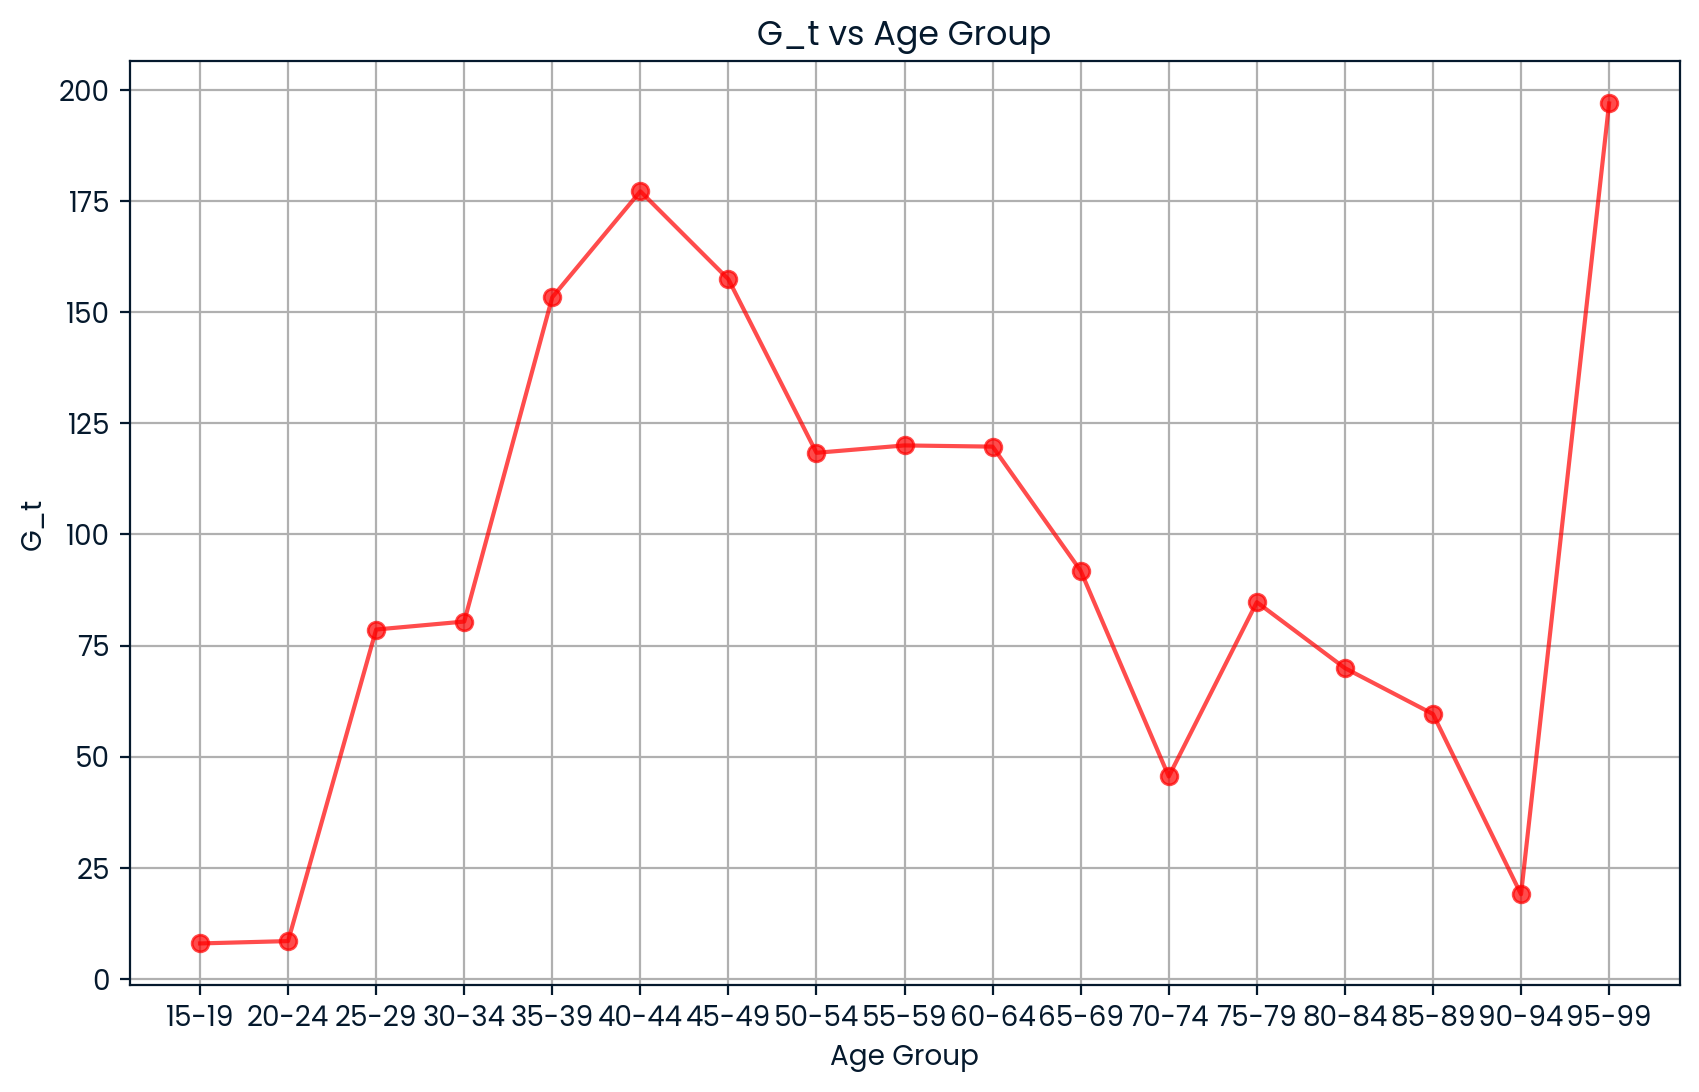

In [10]:
import matplotlib.pyplot as plt

# Plot G_t against age_group in a line chart
plt.figure(figsize=(10, 6))
plt.plot(summary['age_group'], summary['G_t'], marker='o', linestyle='-', alpha=0.7, color = 'red')
plt.title('G_t vs Age Group')
plt.xlabel('Age Group')
plt.ylabel('G_t')
plt.grid(True)
plt.show()

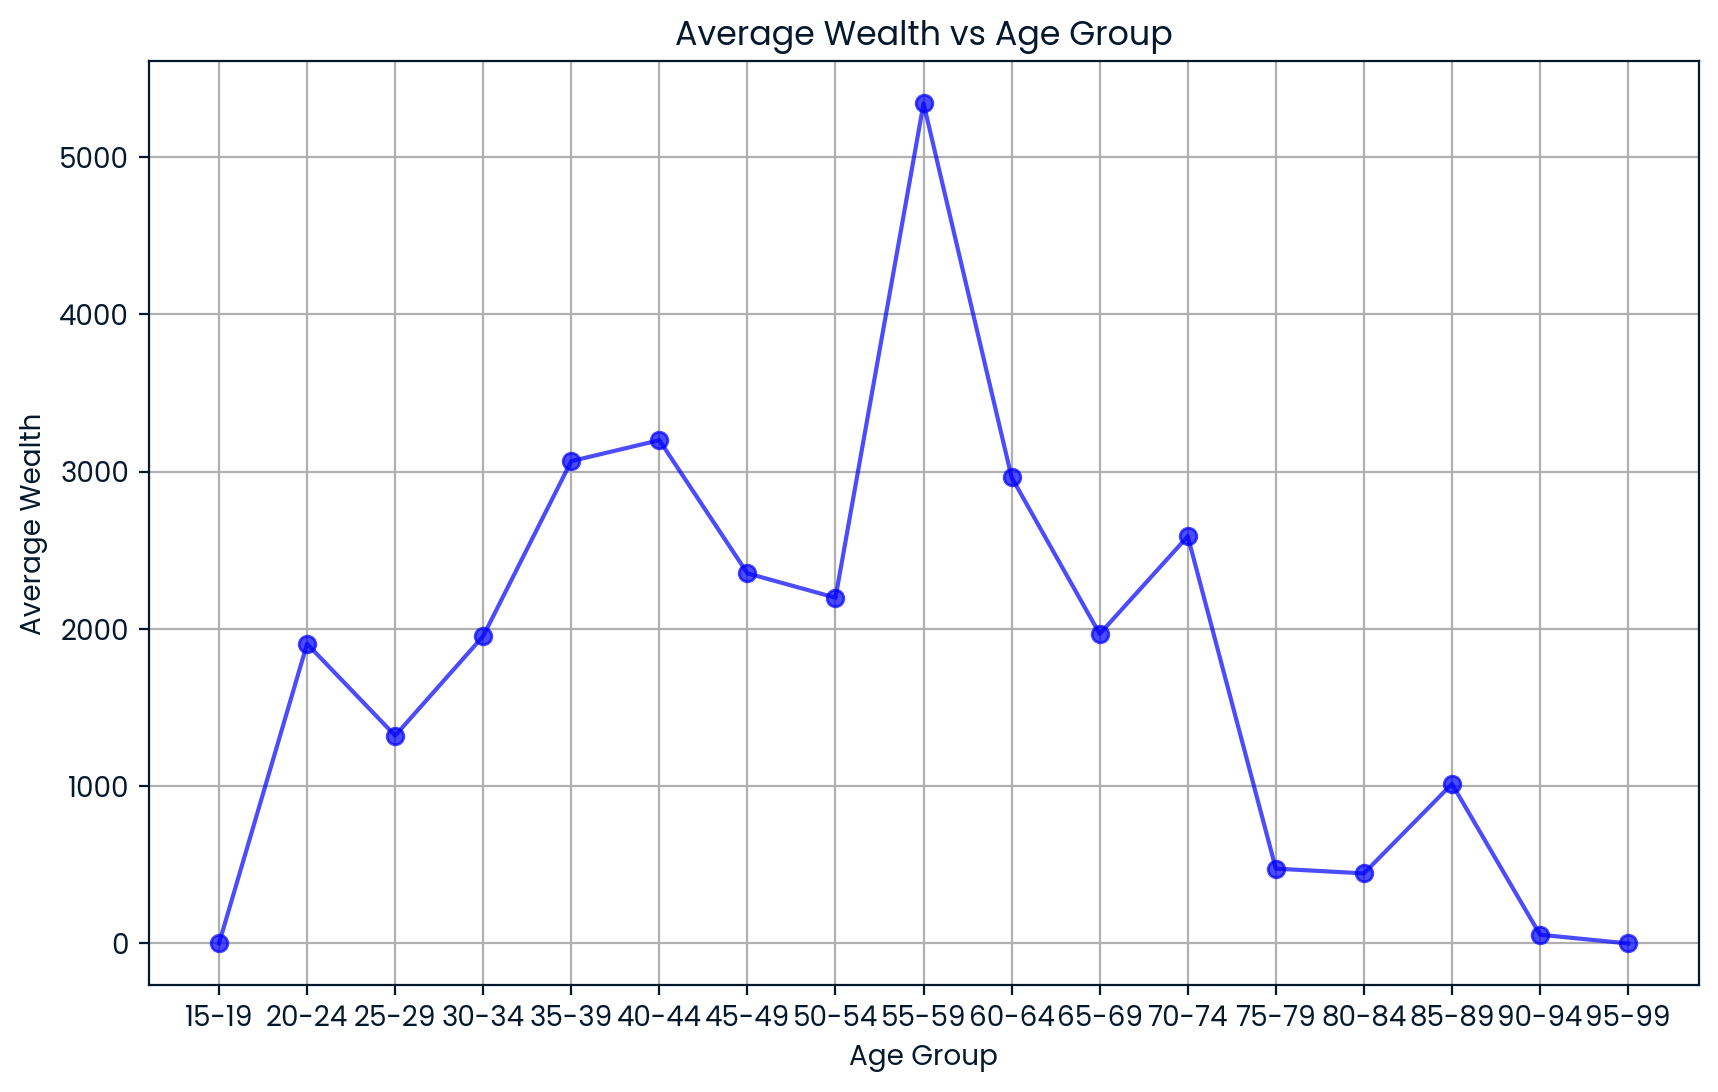

In [12]:
import matplotlib.pyplot as plt

# Plot average_wealth against age_group in a line chart
plt.figure(figsize=(10, 6))
plt.plot(summary['age_group'], summary['average_wealth'], marker='o', linestyle='-', alpha=0.7, color = 'blue')
plt.title('Average Wealth vs Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Wealth')
plt.grid(True)
plt.show()

In [13]:
# ─────────────────────────────────────────────────────────────────────────────
# 0. Imports
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 1. Load raw VHLSS modules
# ─────────────────────────────────────────────────────────────────────────────
df123   = pd.read_csv('muc123a.csv')    # demographics  (person level)
df4a    = pd.read_csv('muc4a.csv')      # income flows  (person level)
df4d    = pd.read_csv('muc4d.csv')      # wealth stocks (household level)
dfhhExp = pd.read_csv('hhexpe08.csv')   # NEW: consumption (household level)

# ─────────────────────────────────────────────────────────────────────────────
# 2. Build member‑level base (gender, role, age, income)
# ─────────────────────────────────────────────────────────────────────────────
df123['ID'] = (
    df123[['tinh','huyen','xa','diaban','hoso']]
    .astype(str).agg('_'.join, axis=1)
)

G_t = df123[['ID','m1ac2','m1ac3','m1ac5']].rename(
        columns={'m1ac2':'gender','m1ac3':'role','m1ac5':'age'}
)
G_t['Income'] = df4a[['m4ac11','m4ac12f']].sum(axis=1, skipna=True)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Keep only households with a male head
# ─────────────────────────────────────────────────────────────────────────────
is_male_head = (
    G_t.groupby('ID')
       .filter(lambda g: ((g['gender']==1) & (g['role']==1)).any())
)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Aggregate income and head age to household level
# ─────────────────────────────────────────────────────────────────────────────
household_income = (
    is_male_head.groupby('ID')['Income'].sum().reset_index(name='total_income')
)
head_age = (
    is_male_head.loc[(is_male_head['gender']==1) & (is_male_head['role']==1)]
              .groupby('ID')['age'].first().reset_index(name='head_age')
)

# ─────────────────────────────────────────────────────────────────────────────
# 5. Bring in wealth (m4d2c2_3)  – household level already
# ─────────────────────────────────────────────────────────────────────────────
df4d['ID'] = (
    df4d[['tinh','huyen','xa','diaban','hoso']]
    .astype(str).agg('_'.join, axis=1)
)
wealth = df4d[['ID','m4d2c2_3']].rename(columns={'m4d2c2_3':'total_wealth'})

# ─────────────────────────────────────────────────────────────────────────────
# 6. Bring in consumption (foodreal + nonfd1rl)  – household level
# ─────────────────────────────────────────────────────────────────────────────
dfhhExp['ID'] = (
    dfhhExp[['tinh','huyen','xa','diaban','hoso']]
    .astype(str).agg('_'.join, axis=1)
)
dfhhExp['total_consumption'] = dfhhExp[['foodreal','nonfd1rl']].sum(axis=1, skipna=True)
consumption = dfhhExp[['ID','total_consumption']]

# ─────────────────────────────────────────────────────────────────────────────
# 7. Merge everything → household_data
# ─────────────────────────────────────────────────────────────────────────────
household_data = (
    household_income
      .merge(head_age,      on='ID', how='left')
      .merge(wealth,        on='ID', how='left')
      .merge(consumption,   on='ID', how='left')
)

# ─────────────────────────────────────────────────────────────────────────────
# 8. Compute G_t (income) + avg wealth + avg consumption by 5‑year age bins
# ─────────────────────────────────────────────────────────────────────────────
household_data['log_total_income'] = np.log(
    household_data['total_income'].clip(lower=1)
)

bins   = np.arange(0,105,5)                  # 0‑4, 5‑9, …, 100‑104
labels = [f'{b}-{b+4}' for b in bins[:-1]]

household_data['age_group'] = pd.cut(
    household_data['head_age'], bins=bins, labels=labels, right=False
)

summary = (
    household_data
      .groupby('age_group')
      .agg(average_log_income = ('log_total_income','mean'),
           average_wealth     = ('total_wealth','mean'),
           average_consumption = ('total_consumption','mean'))
      .dropna()
      .reset_index()
)

summary['G_t'] = np.exp(summary['average_log_income'])

# ─────────────────────────────────────────────────────────────────────────────
# 9. Final output  (age_group | G_t | wealth | consumption)
# ─────────────────────────────────────────────────────────────────────────────
print(summary[['age_group','G_t','average_wealth','average_consumption']])

# Optional: save
summary.to_csv('G_t_wealth_consumption_age5.csv', index=False)


   age_group         G_t  average_wealth  average_consumption
0      15-19    7.980175        0.000000          7640.375360
1      20-24    8.510185     1905.135135         19905.315931
2      25-29   78.599629     1321.551020         20854.533200
3      30-34   80.388930     1954.591290         24874.551502
4      35-39  153.343114     3067.078864         27420.485806
5      40-44  177.186290     3200.217317         30654.035261
6      45-49  157.386007     2353.613285         32917.019420
7      50-54  118.353917     2198.601307         36484.658270
8      55-59  120.013066     5341.731066         32735.944360
9      60-64  119.741284     2963.723192         31858.167642
10     65-69   91.812923     1968.395349         29009.568463
11     70-74   45.536698     2588.915663         24395.620983
12     75-79   84.756616      475.628415         25796.491486
13     80-84   69.919195      445.505618         25163.765763
14     85-89   59.593613     1014.285714         25392.826396
15     9

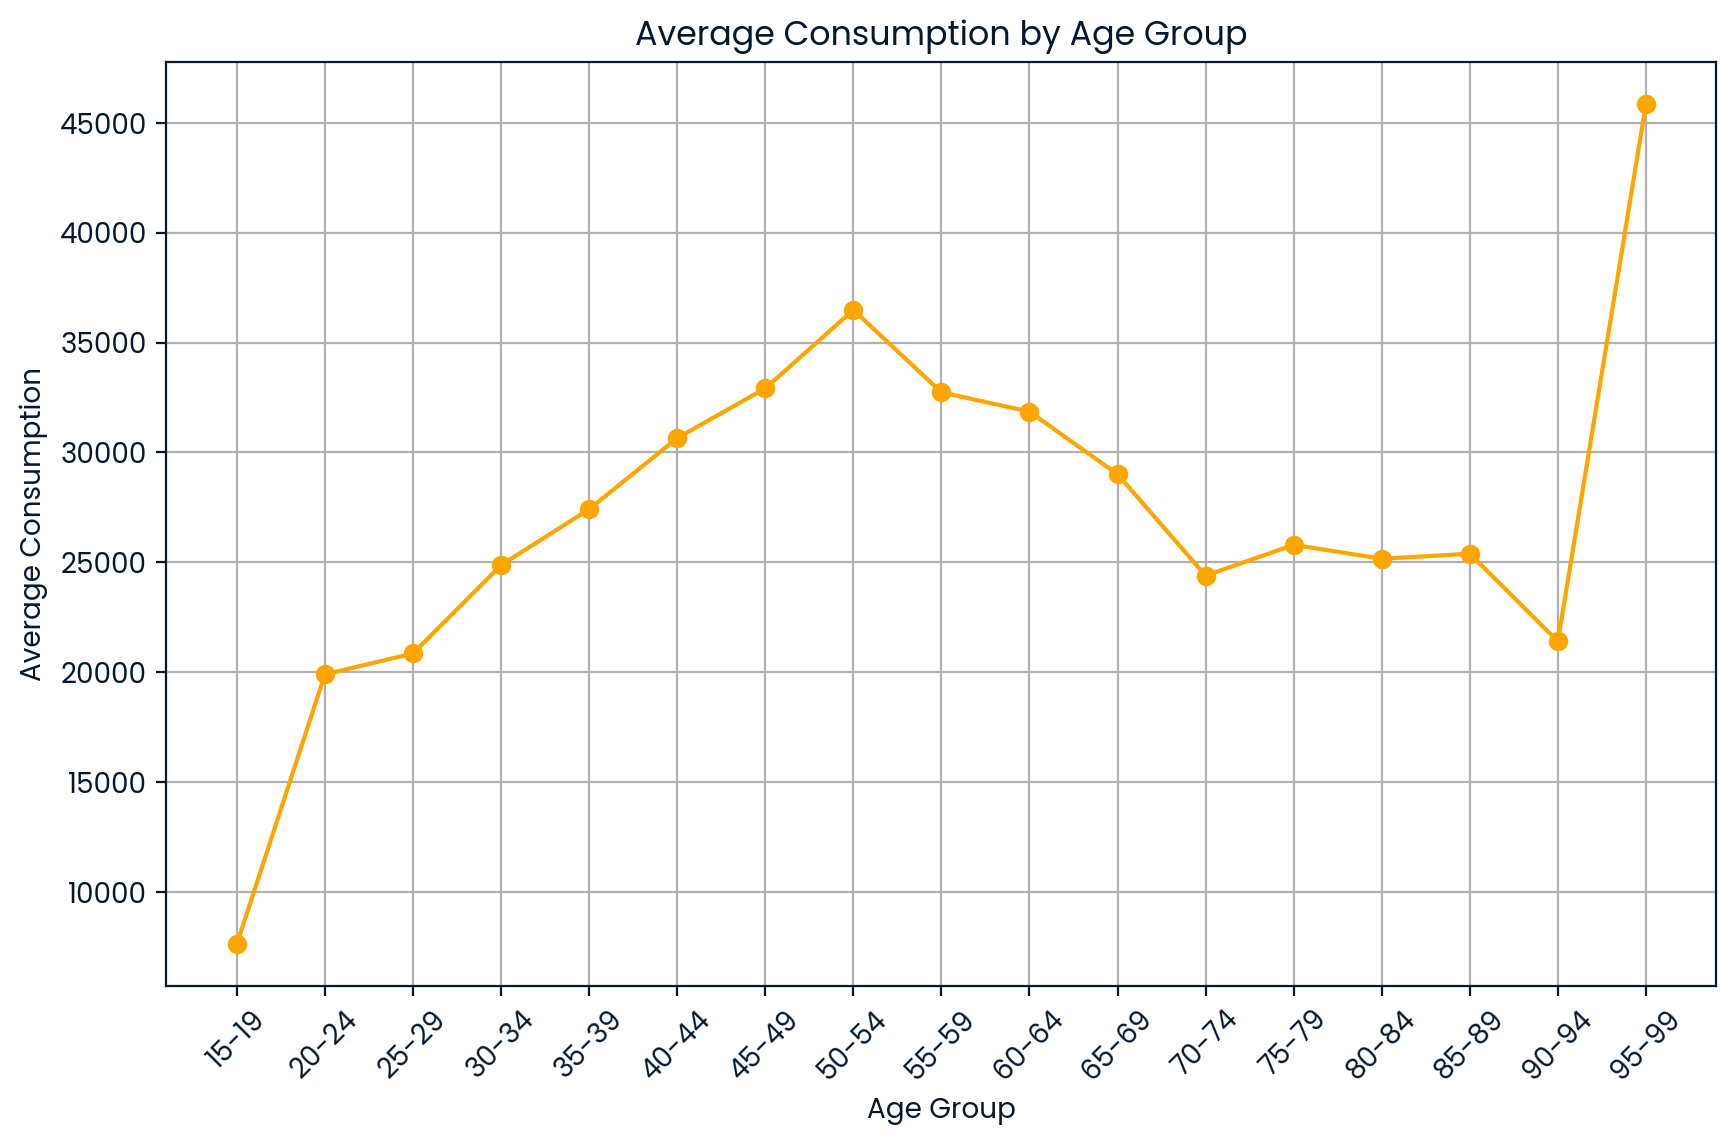

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(summary['age_group'].astype(str), summary['average_consumption'], marker='o', linestyle='-', color='orange')
plt.xlabel('Age Group')
plt.ylabel('Average Consumption')
plt.title('Average Consumption by Age Group')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# 0. Imports
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 1. Load VHLSS modules
# ─────────────────────────────────────────────────────────────────────────────
df123   = pd.read_csv('muc123a.csv')    # demographics (person level)
df4a    = pd.read_csv('muc4a.csv')      # income flows + labour hours (person level)
df4d    = pd.read_csv('muc4d.csv')      # gold/jewellery sales (wealth, HH level)
dfhhExp = pd.read_csv('hhexpe08.csv')   # food & non-food expenditure (HH level)

# ─────────────────────────────────────────────────────────────────────────────
# 2. Member-level base: gender, role, age, income, hours
# ─────────────────────────────────────────────────────────────────────────────
# Household key
df123['ID'] = (
    df123[['tinh', 'huyen', 'xa', 'diaban', 'hoso']]
    .astype(str).agg('_'.join, axis=1)
)

# Core demographic columns
G_t = df123[['ID', 'm1ac2', 'm1ac3', 'm1ac5']].rename(
        columns={'m1ac2': 'gender',
                 'm1ac3': 'role',
                 'm1ac5': 'age'}
)

# Income (row-aligned with df4a)
G_t['Income'] = df4a[['m4ac11', 'm4ac12f']].sum(axis=1, skipna=True)

# Hours = m4ac6 × m4ac7 × m4ac8  (all three in muc4a)
G_t['Hours'] = (
    df4a['m4ac6'].fillna(0) *
    df4a['m4ac7'].fillna(0) *
    df4a['m4ac8'].fillna(0)
)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Keep only male-headed households
# ─────────────────────────────────────────────────────────────────────────────
is_male_head = (
    G_t.groupby('ID')
       .filter(lambda g: ((g['gender'] == 1) & (g['role'] == 1)).any())
)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Aggregate person variables → household level
# ─────────────────────────────────────────────────────────────────────────────
household_income = (
    is_male_head.groupby('ID')['Income'].sum().reset_index(name='total_income')
)
household_hours = (
    is_male_head.groupby('ID')['Hours'].sum().reset_index(name='total_hours')
)
head_age = (
    is_male_head.loc[(is_male_head['gender'] == 1) & (is_male_head['role'] == 1)]
              .groupby('ID')['age'].first().reset_index(name='head_age')
)

# ─────────────────────────────────────────────────────────────────────────────
# 5. Wealth proxy  (gold & jewellery sold)
# ─────────────────────────────────────────────────────────────────────────────
df4d['ID'] = (
    df4d[['tinh', 'huyen', 'xa', 'diaban', 'hoso']]
    .astype(str).agg('_'.join, axis=1)
)
wealth = df4d[['ID', 'm4d2c2_3']].rename(columns={'m4d2c2_3': 'total_wealth'})

# ─────────────────────────────────────────────────────────────────────────────
# 6. Consumption flows
# ─────────────────────────────────────────────────────────────────────────────
dfhhExp['ID'] = (
    dfhhExp[['tinh', 'huyen', 'xa', 'diaban', 'hoso']]
    .astype(str).agg('_'.join, axis=1)
)
dfhhExp['total_consumption'] = (
    dfhhExp[['foodreal', 'nonfd1rl']].sum(axis=1, skipna=True)
)
consumption = dfhhExp[['ID', 'total_consumption']]

# ─────────────────────────────────────────────────────────────────────────────
# 7. Merge all household-level variables
# ─────────────────────────────────────────────────────────────────────────────
household_data = (
    household_income
      .merge(household_hours,  on='ID', how='left')
      .merge(head_age,         on='ID', how='left')
      .merge(wealth,           on='ID', how='left')
      .merge(consumption,      on='ID', how='left')
)

# ─────────────────────────────────────────────────────────────────────────────
# 8. Summaries by 5-year head-age groups
# ─────────────────────────────────────────────────────────────────────────────
household_data['log_total_income'] = np.log(
    household_data['total_income'].clip(lower=1)
)

bins   = np.arange(0, 105, 5)               # 0-4, 5-9, …, 100-104
labels = [f'{b}-{b+4}' for b in bins[:-1]]

household_data['age_group'] = pd.cut(
    household_data['head_age'], bins=bins, labels=labels, right=False
)

summary = (
    household_data
      .groupby('age_group')
      .agg(average_log_income  = ('log_total_income',  'mean'),
           average_wealth      = ('total_wealth',      'mean'),
           average_consumption = ('total_consumption', 'mean'),
           average_hours       = ('total_hours',       'mean'))
      .dropna()
      .reset_index()
)

summary['G_t'] = np.exp(summary['average_log_income'])

# ─────────────────────────────────────────────────────────────────────────────
# 9. Final output
# ─────────────────────────────────────────────────────────────────────────────
print(
    summary[['age_group', 'G_t',
             'average_wealth', 'average_consumption', 'average_hours']]
)

# Optional: save
summary.to_csv('G_t_wealth_consumption_hours_age5.csv', index=False)

   age_group         G_t  average_wealth  average_consumption  average_hours
0      15-19    7.980175        0.000000          7640.375360    1648.800000
1      20-24    8.510185     1905.135135         19905.315931    3816.000000
2      25-29   78.599629     1321.551020         20854.533200    3916.444898
3      30-34   80.388930     1954.591290         24874.551502    4167.802345
4      35-39  153.343114     3067.078864         27420.485806    4271.379600
5      40-44  177.186290     3200.217317         30654.035261    4434.126486
6      45-49  157.386007     2353.613285         32917.019420    4180.133758
7      50-54  118.353917     2198.601307         36484.658270    4120.099129
8      55-59  120.013066     5341.731066         32735.944360    3948.202473
9      60-64  119.741284     2963.723192         31858.167642    3998.867830
10     65-69   91.812923     1968.395349         29009.568463    3891.023256
11     70-74   45.536698     2588.915663         24395.620983    3416.570281

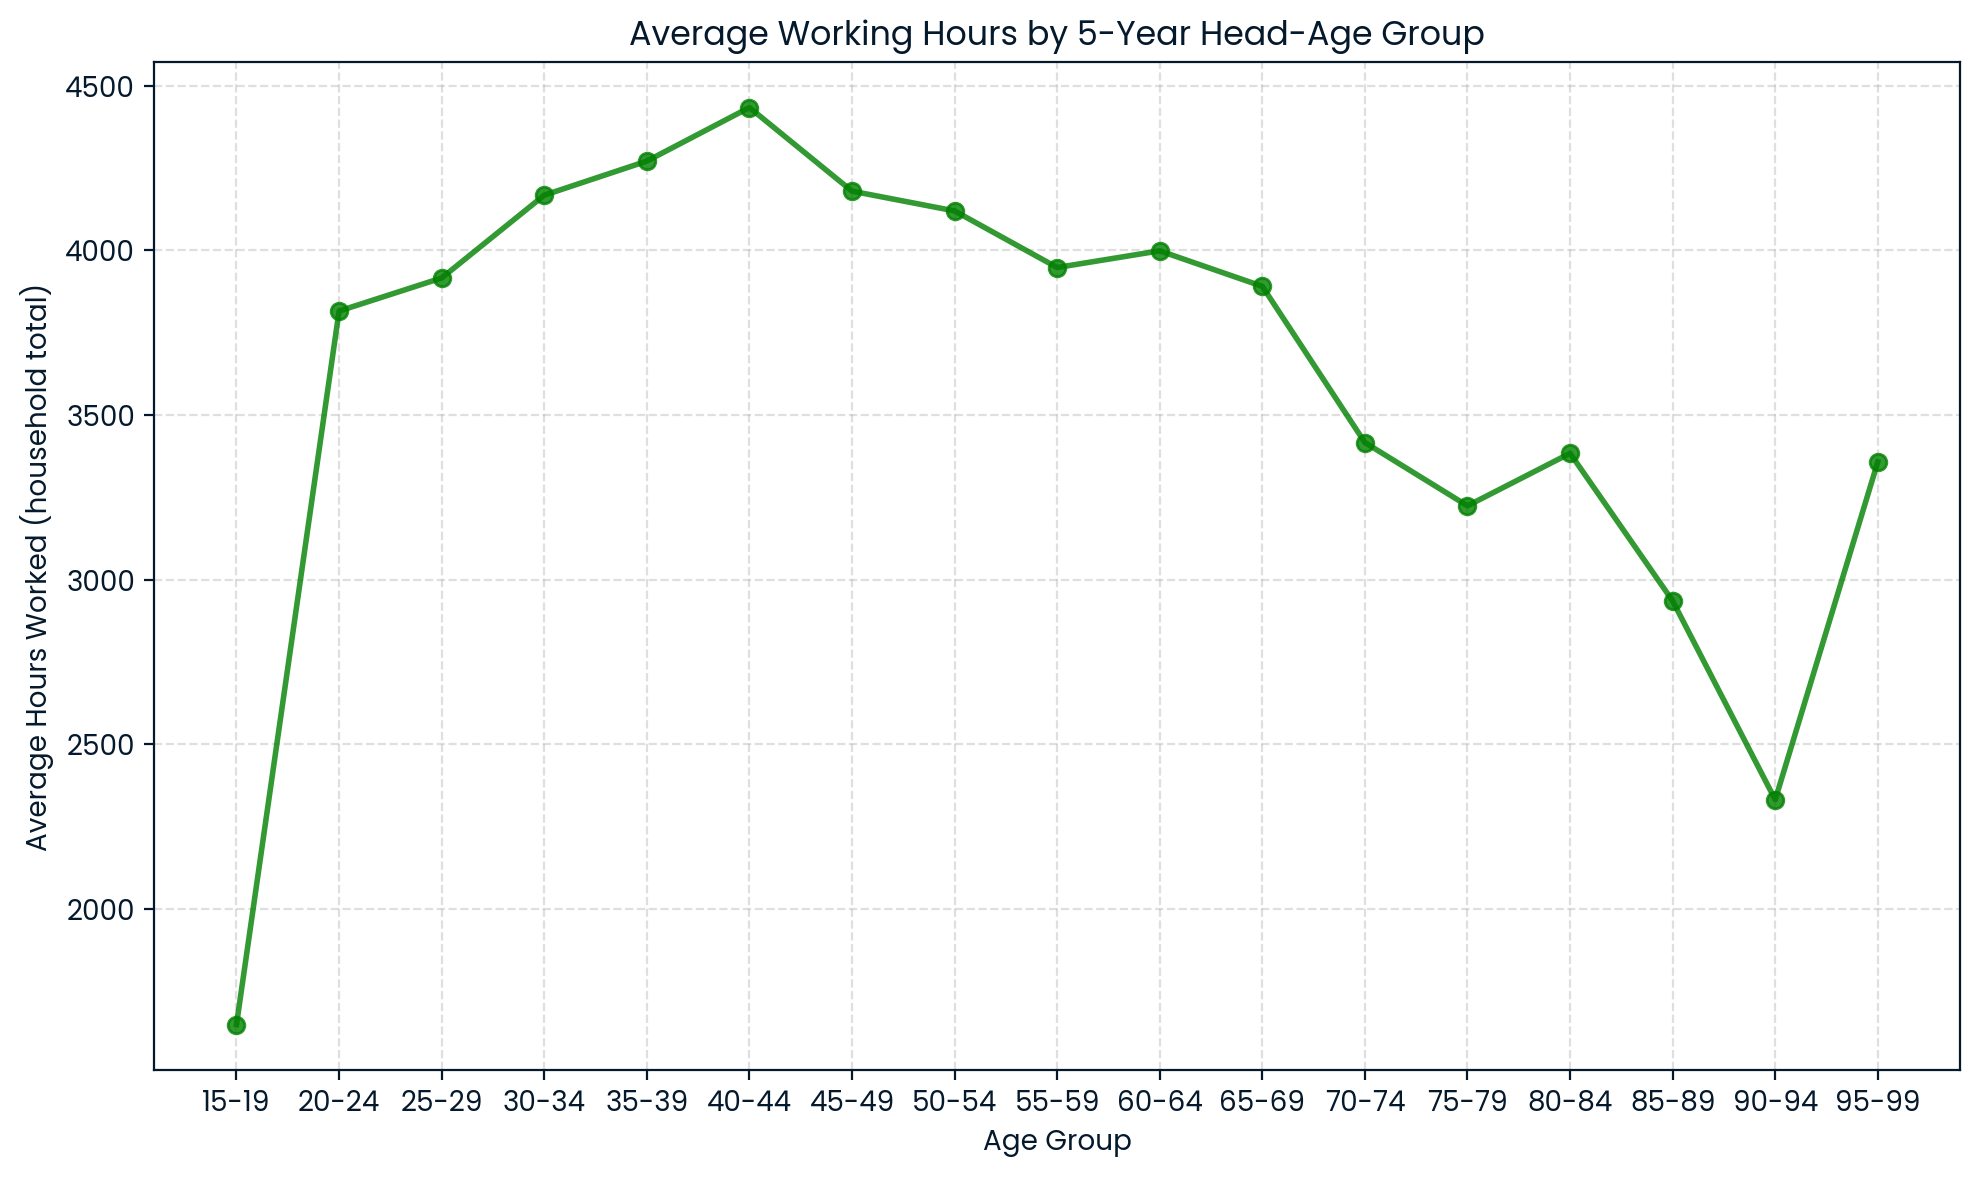

In [4]:
import matplotlib.pyplot as plt

# --- line chart : average_hours vs age_group -------------------------------
plt.figure(figsize=(10, 6))

plt.plot(
    summary['age_group'].astype(str),   # make sure the x-labels are strings
    summary['average_hours'],
    marker='o',
    linestyle='-',
    linewidth=2,
    color='darkorange',                 # choose any colour you like
    alpha=0.8
)

plt.title('Average Working Hours by 5-Year Head-Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Hours Worked (household total)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()